<a href="https://colab.research.google.com/github/nikitakaraevv/reinforcement-learning-algorithms/blob/master/Policy%20optimization/Pong_DeepRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install — upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install pyvirtualdisplay
!pip install piglet
!apt-get install python-opengl -y
!apt install xvfb -y

ERROR: Invalid requirement: '—'
     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers import Monitor
from itertools import count

import random
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable

%matplotlib inline
import math
import glob
import io
import os
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env
    

## Random agent

In [4]:
env = wrap_env(gym.make('Pong-v0'))
observation = env.reset()
new_observation = observation
prev_input = None
done = False
for _ in range(300):
    new_observation, reward, done, info = env.step(random.randint(1,3))
      
env.close()
show_video()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = "/content/drive/My Drive/PongPolicyGrad"

## Policy Gradient model

In [0]:
class Policy_full_connect(nn.Module):
    def __init__(self):
        super(Policy_full_connect, self).__init__()
        self.lin1 = nn.Linear(80*80, 200)
        self.lin2 = nn.Linear(200, 3) 

        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, input):
        x = F.relu(self.lin1(input))
        output = self.lin2(x)
        return F.softmax(output, dim=1)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to('cuda')
        probs = self(Variable(state))
        m = Categorical(probs)
        action = m.sample() 
        self.saved_log_probs.append(m.log_prob(action)) 
        return action.data[0]

In [0]:
class Policy_conv(nn.Module):
    def __init__(self):
        super(Policy_conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(1568, 3)

        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, input):
        x = F.relu(self.bn1((self.conv1(input))))
        x = F.relu(self.bn2((self.conv2(x))))
        x = F.relu(self.bn3((self.conv3(x))))
        output =  F.softmax(self.head(x.view(x.size(0), -1)), dim=1) #soft max is not necessary for computing te q value
        #print("res ",output )
        return output

    def select_action(self, state):
        #print("state shape", state.shape)
        state = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(1)

        probs = self(Variable(state).to('cuda'))
        m = Categorical(probs)
        action = m.sample() 
        self.saved_log_probs.append(m.log_prob(action)) 
        return action.data[0]

In [9]:
os.path.isfile(os.path.join(data_path,'conv_net_370.pkl'))

True

In [0]:
class Trainer():
    def __init__(self, env, model, optimizer, path='', save_fn='log.pkl', restore_fn='log.pkl'):
        self.env = env
        self.model = model
        self.optimizer = optimizer
        
        self.episode_nb = 0
        self.history = []
        self.losses = []

        self.path = path
        self.save_fn = save_fn
        self.restore_fn = restore_fn

    def preprocess(self, I):
        """ preprocess 210x160x3 into 6400 """
        I = I[35:195]
        I = I[::2, ::2, 0]
        I[I == 144] = 0
        I[I == 109] = 0
        I[I != 0 ] = 1
        res = I.astype(np.float)
        return res if 'conv' in str(self.model.__class__) else res.ravel()

    def restore(self):
        restore_path = os.path.join(self.path, self.restore_fn)
        if os.path.isfile(restore_path):
            print(f"Load Policy Network parametets from {restore_path}")
            state = torch.load(restore_path)
            self.model.load_state_dict(state['state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])
            self.episode_nb = state['episode']
            self.history = state['history']
            self.losses = state['losses']
        else:
            print('There is no checkpoint to restore!')

    def save(self):
        state = {
            'episode': self.episode_nb,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'history': self.history,
            'losses': self.losses
        }
        save_path = os.path.join(self.path, self.save_fn)
        torch.save(state, save_path)
        print(f"Saved model parametets to {save_path}")

    def one_batch(self):
        R = 0
        loss = []
        rewards = []
        for r in self.model.rewards[::-1]:
            R = r + 0.99 * R
            rewards.insert(0, R)

        # turn rewards to pytorch tensor and standardize
        rewards = torch.Tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
        
        for log_prob, reward in zip(self.model.saved_log_probs, rewards):
            loss.append(-log_prob * reward)

        self.optimizer.zero_grad()
        loss = torch.cat(loss).sum()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.item())
        # clean rewards and saved_actions
        del self.model.rewards[:]
        del self.model.saved_log_probs[:]

    def train(self, batch_size = 10, save_frequency = 50): 
        self.restore()  
        running_reward = None
        reward_sum = 0
        while True:
            self.episode_nb+=1
            state = self.env.reset()
            #curr_input = self.preprocess(observation) 
            #prev_input = None
            for t in range(10000):
                #print(state.shape)
                state = self.preprocess(state)
                
                #difference = curr_input - prev_input if prev_input is not None else np.zeros(80* 80)
                action = self.model.select_action(state)
                action = action + 1
                
                state, reward, done, _ = self.env.step(action)
                reward_sum += reward

                #prev_input = curr_input
                #curr_input = self.preprocess(new_observation)
                self.model.rewards.append(reward)
                if done:
                    # tracking log
                    self.history.append(reward_sum)
                    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                    print('resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward))
                    reward_sum = 0
                    break
            
            # use policy gradient update model weights
            if self.episode_nb % batch_size == 0:
                print('ep %d: policy network parameters updating...' % (self.episode_nb))
                self.one_batch()

            # Save model
            if self.episode_nb % save_frequency == 0:
                print('Saving model ...')
                self.save()
                

In [0]:
# gym initialization
env = gym.make('Pong-v0')
policy = Policy_conv().to('cuda')#Policy_conv()
optimizer = optim.RMSprop(policy.parameters(), lr=1e-4, weight_decay=0.99)
trainer = Trainer(env, policy, optimizer, path=data_path)#restore_fn='full_connect_3020.pkl')#

In [0]:
trainer.train(batch_size=5)



Load Policy Network parametets from /content/drive/My Drive/PongPolicyGrad/log.pkl
resetting env. episode reward total was -15.000000. running mean: -15.000000
resetting env. episode reward total was -16.000000. running mean: -15.010000
resetting env. episode reward total was -13.000000. running mean: -14.989900
resetting env. episode reward total was -18.000000. running mean: -15.020001
resetting env. episode reward total was -13.000000. running mean: -14.999801
ep 2455: policy network parameters updating...
resetting env. episode reward total was -16.000000. running mean: -15.009803
resetting env. episode reward total was -19.000000. running mean: -15.049705
resetting env. episode reward total was -15.000000. running mean: -15.049208
resetting env. episode reward total was -17.000000. running mean: -15.068716
resetting env. episode reward total was -11.000000. running mean: -15.028029
ep 2460: policy network parameters updating...
resetting env. episode reward total was -14.000000. r

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

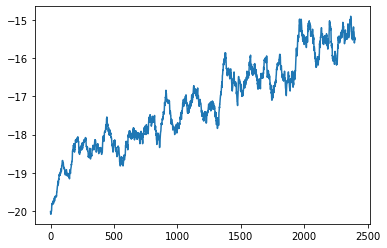

In [15]:
plt.plot(running_mean(trainer.history,50))

In [0]:
def show(threshold, steps=10000):
  running_reward=-21
  while running_reward<threshold:
    obs=[]
    running_reward=0
    show_env = wrap_env(gym.make('Pong-v0'))
    state = show_env.reset()
    for _ in range(steps):
        obs.append(state)
        state = trainer.preprocess(state)
        
        action = trainer.model.select_action(state)
        action = action + 1
        
        state, reward, done, _ = show_env.step(action)
        running_reward+=reward
        if done: break
    

  show_env.close()
  show_video()
  return obs

In [17]:
obs=show(-12)

In [0]:
reward_sum = 0
x_train, y_train, rewards = [],[],[]
observation = env.reset()
prev_input = None
accumulation_steps=10
# main training loop
while (True):
    cur_input = prepro(observation)
    #print(len(cur_input)) — Sanity Check reasons only

    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    #x = torch.tensor(x.astype('float32')).to('cuda')
    # forward the policy network and sample action according to the probability distribution
    x=torch.tensor(x.astype('float32')).to('cuda')
    proba = model(x.unsqueeze(0))
    #print(proba)
    
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == 2 else 0 # 0 and 1 are our labels
    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)
    # do one step in our environment — This is returned by our environment in OpenAI gym. 
    observation, reward, done, info = env.step(action)

    rewards.append(reward)
    reward_sum += reward

    if done:
        history.append(reward_sum)
        print(f"At the end of episode {episode_nb} the total reward was : {reward_sum}")
        if episode_nb>=3000 and reward_sum >=-12:
            break
        else:
            # increment episode number
            episode_nb += 1
            
            # training
            pred = model(torch.stack(x_train))
            
            loss = (criterion(pred,
                              torch.tensor(y_train).to('cuda'),
                              torch.tensor(discount_rewards(rewards, gamma)).to('cuda') ))
            
            loss = loss / accumulation_steps                # Normalize our loss (if averaged)
            loss.backward()                                 # Backward pass
            if episode_nb % accumulation_steps == 0:             # Wait for several backward steps
                optimizer.step()                            # Now we can do an optimizer step
                optimizer.zero_grad()   
                print('update params')
                print(f"Mean of 1 layer weights: {model.lin1.weight.mean()}, bias: {model.lin1.bias.mean()}")
                print(f"Mean of 2 layer weights: {model.lin2.weight.mean()}, bias: {model.lin2.bias.mean()}")
                
                
            # Reinitialization
            x_train, y_train, rewards = [],[],[]
            observation = env.reset()
            reward_sum = 0
            prev_input = None

At the end of episode 201 the total reward was : -21.0
At the end of episode 202 the total reward was : -20.0
At the end of episode 203 the total reward was : -21.0
At the end of episode 204 the total reward was : -21.0
At the end of episode 205 the total reward was : -21.0
At the end of episode 206 the total reward was : -19.0
At the end of episode 207 the total reward was : -20.0
At the end of episode 208 the total reward was : -20.0
At the end of episode 209 the total reward was : -21.0
update params
Mean of 1 layer weights: 1.4079056199989282e-05, bias: -6.636395846726373e-05
Mean of 2 layer weights: -0.002981989411637187, bias: -0.0011068327585235238
At the end of episode 210 the total reward was : -21.0
At the end of episode 211 the total reward was : -21.0
At the end of episode 212 the total reward was : -21.0
At the end of episode 213 the total reward was : -20.0
At the end of episode 214 the total reward was : -20.0
At the end of episode 215 the total reward was : -21.0
At the

KeyboardInterrupt: ignored

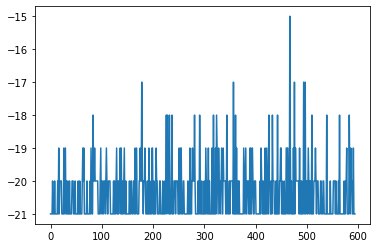

In [0]:
plt.plot(history)